# 3.6

# VGG-19&16 Teacher

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models

class TeacherModel(nn.Module):
    def __init__(self, model_type="vgg16"):
        super().__init__()
        if model_type == "vgg16":
            model = models.vgg16(pretrained=True)
        elif model_type == "vgg19":
            model = models.vgg19(pretrained=True)
        
        self.features = model.features
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 100)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


# VGG-11 Student

In [2]:
class StudentModel(nn.Module):
    def __init__(self):
        super().__init__()
        model = models.vgg11(pretrained=True)
        self.features = model.features
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),  
            nn.BatchNorm1d(4096),      
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.Linear(4096, 1024),   
            nn.BatchNorm1d(1024),      
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.Linear(1024, 100)         
        )

        
        self.apply(self._init_weights)
        
    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, 0, 0.01)
            nn.init.constant_(m.bias, 0)
            
    def forward(self, x):
        x = self.features(x)
        #x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Data Loader

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
import math

def load_data(batch_size=128):
    """Load CIFAR-100 dataset."""
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
        transforms.Resize(224),
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
        transforms.Resize(224),
    ])
    
    trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    
    testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    return trainloader, testloader

# Train Teachers

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def train_teacher(model, trainloader, testloader, device, epochs=5, model_type="vgg16"):
    """Train the teacher model on CIFAR-100 and save the best model."""
    save_path = f"best_teacher_{model_type}.pth"
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4) 
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    best_acc = 0
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in tqdm(trainloader, desc=f'Teacher Training Epoch {epoch + 1}', unit='batch'):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        acc = 100. * correct / total
        print(f'Teacher ({model_type}) Epoch {epoch + 1}: Validation Accuracy: {acc:.2f}%')
        
        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), save_path)
            print(f'Model saved as {save_path} with accuracy: {acc:.2f}%')
        
        scheduler.step()
    
    model.load_state_dict(torch.load(save_path))
    return model


In [5]:

trainloader, testloader = load_data(batch_size=128)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

teacher_model_vgg16 = TeacherModel("vgg16").to(device)
trained_teacher_vgg16 = train_teacher(teacher_model_vgg16, trainloader, testloader, device, epochs=7, model_type="vgg16")

teacher_model_vgg19 = TeacherModel("vgg19").to(device)
trained_teacher_vgg19 = train_teacher(teacher_model_vgg19, trainloader, testloader, device, epochs=7, model_type="vgg19")

100%|██████████| 169001437/169001437 [00:08<00:00, 20877283.58it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 149MB/s] 
Teacher Training Epoch 1: 100%|██████████| 391/391 [06:18<00:00,  1.03batch/s]


Teacher (vgg16) Epoch 1: Validation Accuracy: 63.52%
Model saved as best_teacher_vgg16.pth with accuracy: 63.52%


Teacher Training Epoch 2: 100%|██████████| 391/391 [06:17<00:00,  1.04batch/s]


Teacher (vgg16) Epoch 2: Validation Accuracy: 69.09%
Model saved as best_teacher_vgg16.pth with accuracy: 69.09%


Teacher Training Epoch 3: 100%|██████████| 391/391 [06:17<00:00,  1.03batch/s]


Teacher (vgg16) Epoch 3: Validation Accuracy: 72.56%
Model saved as best_teacher_vgg16.pth with accuracy: 72.56%


Teacher Training Epoch 4: 100%|██████████| 391/391 [06:17<00:00,  1.04batch/s]


Teacher (vgg16) Epoch 4: Validation Accuracy: 74.85%
Model saved as best_teacher_vgg16.pth with accuracy: 74.85%


Teacher Training Epoch 5: 100%|██████████| 391/391 [06:17<00:00,  1.04batch/s]


Teacher (vgg16) Epoch 5: Validation Accuracy: 76.90%
Model saved as best_teacher_vgg16.pth with accuracy: 76.90%


Teacher Training Epoch 6: 100%|██████████| 391/391 [06:17<00:00,  1.04batch/s]


Teacher (vgg16) Epoch 6: Validation Accuracy: 78.55%
Model saved as best_teacher_vgg16.pth with accuracy: 78.55%


Teacher Training Epoch 7: 100%|██████████| 391/391 [06:17<00:00,  1.03batch/s]


Teacher (vgg16) Epoch 7: Validation Accuracy: 79.05%
Model saved as best_teacher_vgg16.pth with accuracy: 79.05%


/tmp/ipykernel_30/212184395.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))
/opt/conda/lib/python3.10/site-packages/torchvi

Teacher (vgg19) Epoch 1: Validation Accuracy: 63.82%
Model saved as best_teacher_vgg19.pth with accuracy: 63.82%


Teacher Training Epoch 2: 100%|██████████| 391/391 [07:18<00:00,  1.12s/batch]


Teacher (vgg19) Epoch 2: Validation Accuracy: 69.64%
Model saved as best_teacher_vgg19.pth with accuracy: 69.64%


Teacher Training Epoch 3: 100%|██████████| 391/391 [07:18<00:00,  1.12s/batch]


Teacher (vgg19) Epoch 3: Validation Accuracy: 72.43%
Model saved as best_teacher_vgg19.pth with accuracy: 72.43%


Teacher Training Epoch 4: 100%|██████████| 391/391 [07:18<00:00,  1.12s/batch]


Teacher (vgg19) Epoch 4: Validation Accuracy: 74.48%
Model saved as best_teacher_vgg19.pth with accuracy: 74.48%


Teacher Training Epoch 5: 100%|██████████| 391/391 [07:18<00:00,  1.12s/batch]


Teacher (vgg19) Epoch 5: Validation Accuracy: 76.63%
Model saved as best_teacher_vgg19.pth with accuracy: 76.63%


Teacher Training Epoch 6: 100%|██████████| 391/391 [07:18<00:00,  1.12s/batch]


Teacher (vgg19) Epoch 6: Validation Accuracy: 78.35%
Model saved as best_teacher_vgg19.pth with accuracy: 78.35%


Teacher Training Epoch 7: 100%|██████████| 391/391 [07:19<00:00,  1.12s/batch]


Teacher (vgg19) Epoch 7: Validation Accuracy: 79.09%
Model saved as best_teacher_vgg19.pth with accuracy: 79.09%


**Train Student**

In [6]:

trainloader, testloader = load_data(batch_size=128)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

student_model_vgg11 = StudentModel().to(device) 
trained_student_vgg11 = train_teacher(student_model_vgg11, trainloader, testloader, device, epochs=2, model_type="vgg11")


Files already downloaded and verified
Files already downloaded and verified


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:02<00:00, 206MB/s] 
Teacher Training Epoch 1: 100%|██████████| 391/391 [03:27<00:00,  1.89batch/s]


Teacher (vgg11) Epoch 1: Validation Accuracy: 20.96%
Model saved as best_teacher_vgg11.pth with accuracy: 20.96%


Teacher Training Epoch 2: 100%|██████████| 391/391 [03:27<00:00,  1.88batch/s]


Teacher (vgg11) Epoch 2: Validation Accuracy: 28.99%
Model saved as best_teacher_vgg11.pth with accuracy: 28.99%


/tmp/ipykernel_30/212184395.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import pandas as pd  

def train_student_with_logit_matching(student, teacher, trainloader, device, epochs=5, alpha=0.5, T=2.0, save_path="student_with_logit_matching.pth", csv_path="logit_matching_metrics.csv"):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(student.parameters(), lr=1e-4)  
    teacher.eval() 
    metrics = {
        "Epoch": [],
        "Loss": [],
        "Accuracy": []
    }

    for epoch in range(epochs):
        student.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in tqdm(trainloader, desc=f'Student Training with LM: Epoch {epoch + 1}', unit='batch'):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.no_grad():
                teacher_outputs = teacher(inputs)

            student_outputs = student(inputs)
            teacher_logits = F.softmax(teacher_outputs / T, dim=1)

            loss = alpha * criterion(student_outputs, labels) + (1 - alpha) * F.kl_div(
                F.log_softmax(student_outputs / T, dim=1), teacher_logits, reduction='batchmean'
            )
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = student_outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100. * correct / total
        print(f'Epoch {epoch + 1}: Loss: {epoch_loss:.3f}, Acc: {epoch_acc:.2f}%')

        metrics["Epoch"].append(epoch + 1)
        metrics["Loss"].append(epoch_loss)
        metrics["Accuracy"].append(epoch_acc)

    metrics_df = pd.DataFrame(metrics)
    metrics_df.to_csv(csv_path, index=False)
    print(f"Training metrics saved to {csv_path}")

    torch.save(student.state_dict(), save_path)
    print(f"Logit-Matching trained student model saved to {save_path}")

In [8]:

teacher_model_vgg16 = TeacherModel("vgg16").to(device)
teacher_model_vgg16.load_state_dict(torch.load("best_teacher_vgg16.pth"))

teacher_model_vgg19 = TeacherModel("vgg19").to(device)
teacher_model_vgg19.load_state_dict(torch.load("best_teacher_vgg19.pth"))

student_model_vgg11_from_vgg16 = StudentModel().to(device)
student_model_vgg11_from_vgg16.load_state_dict(torch.load("best_teacher_vgg11.pth"))

trained_student_vgg11_from_vgg16 = train_student_with_logit_matching(
    student=student_model_vgg11_from_vgg16, 
    teacher=teacher_model_vgg16, 
    trainloader=trainloader, 
    device=device, 
    epochs=5, 
    alpha=0.5, 
    T=2.0, 
    save_path="student_with_logit_matching_vgg16.pth",
    csv_path="logit_matching_metrics_vgg16.csv" 
)



/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_30/3975412618.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In

Epoch 1: Loss: 2.555, Acc: 30.33%


Student Training with LM: Epoch 2: 100%|██████████| 391/391 [05:15<00:00,  1.24batch/s]


Epoch 2: Loss: 2.144, Acc: 38.57%


Student Training with LM: Epoch 3: 100%|██████████| 391/391 [05:16<00:00,  1.24batch/s]


Epoch 3: Loss: 1.849, Acc: 44.96%


Student Training with LM: Epoch 4: 100%|██████████| 391/391 [05:16<00:00,  1.24batch/s]


Epoch 4: Loss: 1.628, Acc: 49.95%


Student Training with LM: Epoch 5: 100%|██████████| 391/391 [05:16<00:00,  1.24batch/s]


Epoch 5: Loss: 1.439, Acc: 54.27%
Training metrics saved to logit_matching_metrics_vgg16.csv
Logit-Matching trained student model saved to student_with_logit_matching_vgg16.pth


/tmp/ipykernel_30/3975412618.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  student_model_vgg11_from_vgg19.load_state_dict(torch.load("finetuned_student_vgg11.pth"))


FileNotFoundError: [Errno 2] No such file or directory: 'finetuned_student_vgg11.pth'

In [9]:
# # Load the fine-tuned student model for VGG-19
# student_model_vgg11_from_vgg19 = StudentModel().to(device)
# student_model_vgg11_from_vgg19.load_state_dict(torch.load("best_teacher_vgg11.pth"))

# # Train Student Model with VGG-19 as the teacher
# trained_student_vgg11_from_vgg19 = train_student_with_logit_matching(
#     student=student_model_vgg11_from_vgg19, 
#     teacher=teacher_model_vgg19,  # Use the loaded VGG-19 model
#     trainloader=trainloader, 
#     device=device, 
#     epochs=5, 
#     alpha=0.5, 
#     T=2.0, 
#     save_path="student_with_logit_matching_vgg19.pth",
#     csv_path="logit_matching_metrics_vgg19.csv"  # Save metrics for VGG-19
# )

import torch

# Set up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import torch
import torchvision.models as models
trainloader, testloader = load_data(batch_size=128)
teacher_model_vgg19 = models.vgg19(weights='VGG19_Weights.IMAGENET1K_V1')
teacher_model_vgg19.classifier[6] = torch.nn.Linear(4096, 100) 
teacher_model_vgg19 = teacher_model_vgg19.to(device)

checkpoint = torch.load("/kaggle/input/vgg19teacher/pytorch/default/1/best_teacher_vgg19.pth")
teacher_model_vgg19.load_state_dict(checkpoint, strict=False)
teacher_model_vgg19.eval() 

student_model_vgg11_from_vgg19 = StudentModel().to(device)  
student_model_vgg11_from_vgg19.load_state_dict(torch.load("/kaggle/input/vgg11student/pytorch/default/1/best_teacher_vgg11.pth"))
student_model_vgg11_from_vgg19.eval() 

trained_student_vgg11_from_vgg19 = train_student_with_logit_matching(
    student=student_model_vgg11_from_vgg19, 
    teacher=teacher_model_vgg19, 
    trainloader=trainloader, 
    device=device, 
    epochs=5, 
    alpha=0.5, 
    T=2.0, 
    save_path="student_with_logit_matching_vgg19.pth",
    csv_path="logit_matching_metrics_vgg19.csv"  
)



100%|██████████| 169001437/169001437 [00:04<00:00, 34822279.61it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


/tmp/ipykernel_30/3927373436.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/kaggle/input/vgg19teacher/pytorch/default/1/best_teacher_vgg19.pt

Epoch 1: Loss: 2.577, Acc: 30.43%


Student Training with LM: Epoch 2: 100%|██████████| 391/391 [05:30<00:00,  1.18batch/s]


Epoch 2: Loss: 2.165, Acc: 38.62%


Student Training with LM: Epoch 3: 100%|██████████| 391/391 [05:30<00:00,  1.18batch/s]


Epoch 3: Loss: 1.877, Acc: 44.76%


Student Training with LM: Epoch 4: 100%|██████████| 391/391 [05:30<00:00,  1.18batch/s]


Epoch 4: Loss: 1.653, Acc: 49.77%


Student Training with LM: Epoch 5: 100%|██████████| 391/391 [05:30<00:00,  1.18batch/s]


Epoch 5: Loss: 1.472, Acc: 54.14%
Training metrics saved to logit_matching_metrics_vgg19.csv
Logit-Matching trained student model saved to student_with_logit_matching_vgg19.pth


In [11]:
def evaluate_model(student, testloader, device):
    student.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = student(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    accuracy = 100. * correct / total
    print(f'Model Evaluation Accuracy: {accuracy:.2f}%')
    return accuracy

student_vgg16 = StudentModel().to(device)
student_vgg16.load_state_dict(torch.load("/kaggle/input/lm_student_vgg16/pytorch/default/1/student_with_logit_matching_vgg16.pth"))
# student_vgg16.load_state_dict(torch.load("student_with_logit_matching_vgg16.pth"))
accuracy_vgg16 = evaluate_model(student_vgg16, testloader, device)

student_vgg19 = StudentModel().to(device)
student_vgg19.load_state_dict(torch.load("student_with_logit_matching_vgg19.pth"))
accuracy_vgg19 = evaluate_model(student_vgg19, testloader, device)

print(f'Accuracy with VGG-16 Teacher: {accuracy_vgg16:.2f}%')
print(f'Accuracy with VGG-19 Teacher: {accuracy_vgg19:.2f}%')


/tmp/ipykernel_30/796400682.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  student_vgg16.load_state_dict(torch.load("/kaggle/input/lm_student_vgg16/pytorch/default/1/s

Model Evaluation Accuracy: 54.49%


/tmp/ipykernel_30/796400682.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  student_vgg19.load_state_dict(torch.load("student_with_logit_matching_vgg19.pth"))


Model Evaluation Accuracy: 55.07%
Accuracy with VGG-16 Teacher: 54.49%
Accuracy with VGG-19 Teacher: 55.07%


In [1]:
import pandas as pd

vgg16_student_df = pd.read_csv('/kaggle/input/vgg16student/logit_matching_metrics_vgg16.csv')
vgg19_student_df = pd.read_csv('/kaggle/input/vgg19-student/logit_matching_metrics_vgg19.csv')

print("VGG-16 Student Data:")
print(vgg16_student_df.head())

print("\nVGG-19 Student Data:")
print(vgg19_student_df.head())


VGG-16 Student Data:
   Epoch      Loss  Accuracy
0      1  2.554620    30.330
1      2  2.144488    38.566
2      3  1.849366    44.960
3      4  1.627600    49.948
4      5  1.439238    54.266

VGG-19 Student Data:
   Epoch      Loss  Accuracy
0      1  2.576930    30.432
1      2  2.164691    38.618
2      3  1.877091    44.760
3      4  1.652985    49.772
4      5  1.472052    54.140


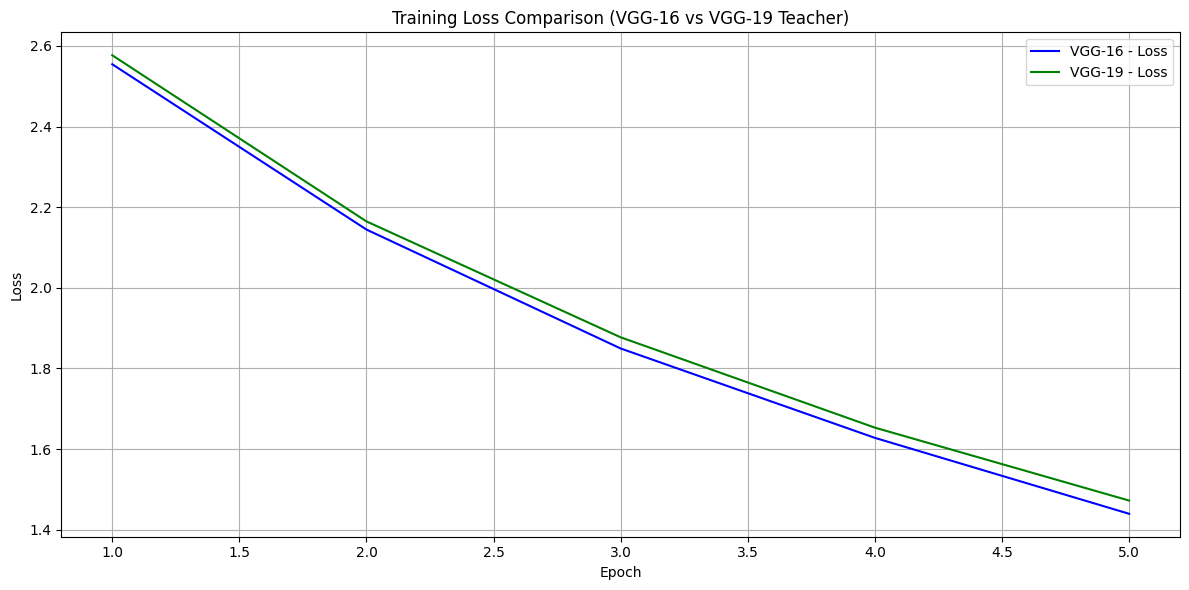

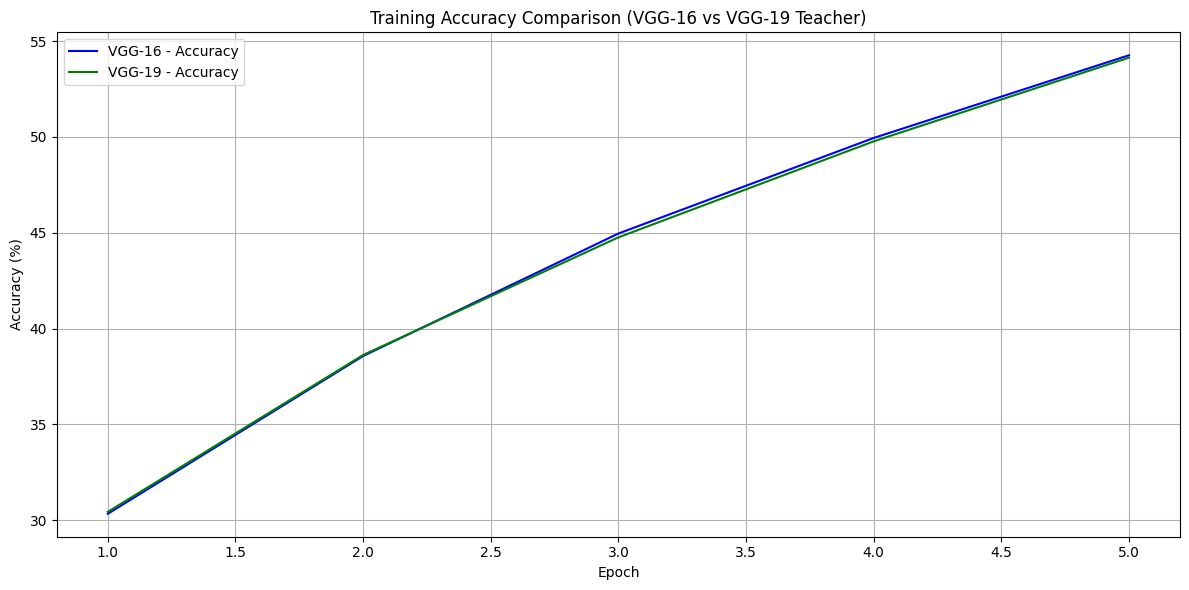

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(vgg16_student_df['Epoch'], vgg16_student_df['Loss'], label='VGG-16 - Loss', color='b', linestyle='solid')
plt.plot(vgg19_student_df['Epoch'], vgg19_student_df['Loss'], label='VGG-19 - Loss', color='g', linestyle='solid')

plt.title('Training Loss Comparison (VGG-16 vs VGG-19 Teacher)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(vgg16_student_df['Epoch'], vgg16_student_df['Accuracy'], label='VGG-16 - Accuracy', color='b', linestyle='solid')
plt.plot(vgg19_student_df['Epoch'], vgg19_student_df['Accuracy'], label='VGG-19 - Accuracy', color='g', linestyle='solid')

plt.title('Training Accuracy Comparison (VGG-16 vs VGG-19 Teacher)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()